In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [31]:
df = pd.read_csv('pokemon_data_real_names_10k.csv')
df.head()

,ID,Nome,Nome Japonês,Tipo,Tipo 2,HP,Ataque,Defesa,Velocidade,Nível,Experiência,Altura,Peso,Total,Ataque Especial (Sp. Atk),Defesa Especial (Sp. Def),Geração,É Lendário,Percentual Masculino,Classificação,Taxa de Captura,Passos para Chocar,Habilidades,Crescimento de Experiência,Felicidade Base
0,1,Raticate,Olivia,Lutador,Fada,35.0,85.0,119.0,75.0,62,7214.0,NaN,255.42,471,14.0,138.0,7,0,98.141206,they,76.0,9226.0,heavy,NaN,41.0
1,2,Squirtle,Richard,Fogo,Gelo,185.0,104.0,141.0,80.0,7,NaN,0.89,225.18,703,119.0,99.0,6,0,77.543063,full,129.0,2247.0,score,1557745.0,94.0
2,3,Mewtwo,Deborah,Elétrico,Grama,56.0,98.0,107.0,90.0,52,8731.0,2.01,159.85,603,139.0,12.0,7,0,54.735070,college,194.0,NaN,NaN,1499489.0,59.0
3,4,Rattata,Mikayla,Grama,NaN,36.0,69.0,43.0,70.0,83,2761.0,2.03,259.16,592,136.0,NaN,1,0,72.212995,player,192.0,8067.0,me,973080.0,197.0
4,5,Magmar,Wayne,Fantasma,Lutador,150.0,71.0,61.0,67.0,4,8088.0,1.51,134.16,528,91.0,129.0,2,0,50.127331,treat,205.0,6795.0,why,606249.0,81.0


In [32]:
# verificando proporção de nulos nas colunas que possuem algum nulo
df.loc[:, df.isnull().mean() > 0].isnull().mean().sort_values()

Classificação                 0.0100
Percentual Masculino          0.0200
Ataque                        0.0500
Habilidades                   0.0500
Ataque Especial (Sp. Atk)     0.0500
Defesa Especial (Sp. Def)     0.0500
Passos para Chocar            0.0500
Taxa de Captura               0.0500
Crescimento de Experiência    0.0500
Felicidade Base               0.0500
Experiência                   0.1000
HP                            0.1000
Defesa                        0.1500
Velocidade                    0.2000
Altura                        0.2300
Peso                          0.3000
Tipo 2                        0.7474
dtype: float64

In [33]:
# não vamos considerar as colunas que possuem mais de 10% de nulos
missing_prop = df.loc[:, df.isnull().mean() > 0].isnull().mean().sort_values()
cols_to_drop = missing_prop[missing_prop > 0.1].index
df = df.drop(columns=cols_to_drop)
df.shape

(10000, 20)

In [34]:
# Identificar colunas numéricas e categóricas
numerical_cols = df.select_dtypes(exclude='object').columns.tolist()
categorical_cols = df.select_dtypes(include='object').columns.tolist()

# Remover a coluna 'Nível' das colunas numéricas
numerical_cols = [col for col in numerical_cols if col != 'Nível']

In [35]:
# Separar features (X) e target (y)
X = df.drop('Nível', axis=1)
y = df['Nível']

In [36]:
# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 19), (2000, 19), (8000,), (2000,))

In [38]:
# tratamento das variáveis, sempre depois de splittar entre treino e teste, não quero que no meu teste tenha informação do treino

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer2', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Transformar os dados de treino e teste
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Aplicar seleção de variância
selection = VarianceThreshold(threshold=0.01)
X_train_filtered = selection.fit_transform(X_train_transformed)
X_test_filtered = selection.transform(X_test_transformed)

# Treinar o modelo
rf = RandomForestRegressor()
rf.fit(X_train_filtered, y_train)

RandomForestRegressor()

In [39]:
y_pred = rf.predict(X_test_filtered)
y_pred

array([55.36, 59.23, 44.05, ..., 43.71, 53.49, 52.53])

In [40]:
mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse:.2f}")

MSE: 827.96


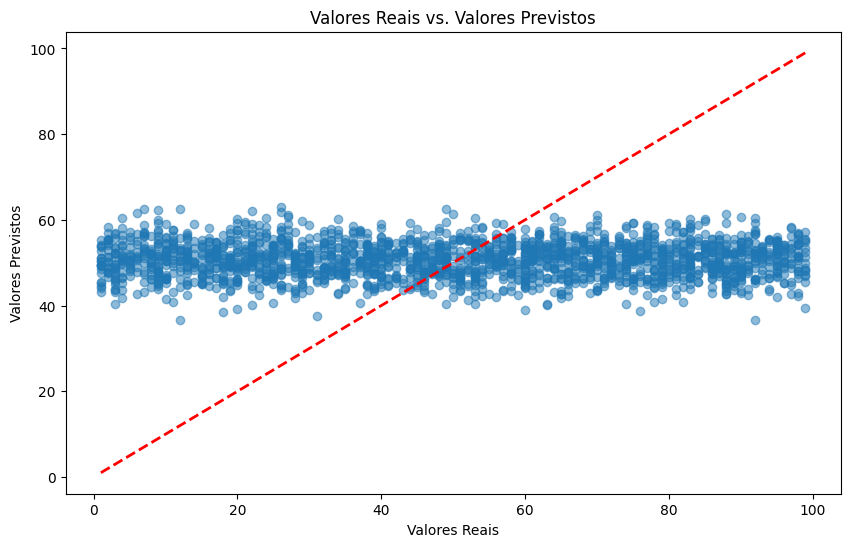

In [44]:
import matplotlib.pyplot as plt

# Plotar os valores reais vs. valores previstos
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores Reais')
plt.ylabel('Valores Previstos')
plt.title('Valores Reais vs. Valores Previstos')
plt.show()

Percebemos que no meio do gráfico está prevendo bem, iremos tratar isso em seguida